In [1]:
!pip install modin[dask]

In [2]:
#import pandas as pd
import modin.pandas as pd
AccountSummary = pd.read_excel('data_mergered.xlsx')

To request implementation, send an email to feature_requests@modin.org.


#### Using modin (dask engine) to enhace pandas efficiency

In [3]:
AccountSummary.head(10)

,ACCNumber,AccAge,DDABal,Dep,DepAmt,CashBk,Checks,DirDep,NSF,NSFAmt,...,5_NJ_Investment,5_CT_Essencials,5_CT_Superfluous,5_CT_Investment,5_PA_Essencials,5_PA_Superfluous,5_PA_Investment,Ans1,Ans2,Ans3
0,1,114,-7.28,81,8406.6336,155.09,43,1,1,420.39,...,-4327.61,-8068.93,-4447.45,-10377.91,-7924.94,-7331.02,-4635.20,1,0,1
1,2,81,95.85,76,24926.2839,170.68,55,1,1,438.14,...,-4233.55,-2403.87,-3188.15,-704.10,-3855.82,-2243.07,-1326.55,1,2,1
2,3,14,0.60,71,56518.4713,120.70,8,0,0,0.00,...,-2831.33,-2860.54,-2516.57,-220.48,-2765.80,-2830.02,-2992.83,2,2,1
3,4,120,88.61,7,75236.8688,140.32,39,0,1,270.76,...,-807.58,-1273.60,-1488.84,-249.16,-522.50,-1678.39,-1161.60,2,1,2
4,6,112,57.28,23,61677.7342,180.06,66,1,0,0.00,...,-3843.99,-5038.31,-6392.94,-8545.41,-7180.33,-2926.66,-5266.39,1,0,1
5,7,137,41.01,59,41630.1750,13.71,49,1,0,0.00,...,-2958.77,-7569.07,-5084.58,-4676.65,-4601.01,-7548.90,-1968.36,1,0,1
6,8,84,36.31,78,28211.7485,201.20,32,1,1,258.34,...,-3855.84,-2989.39,-2998.26,-4960.99,-2341.66,-2239.87,-3149.12,1,2,2
7,9,101,42.83,116,34020.5541,59.79,88,0,1,444.97,...,-2779.77,-2369.59,-3947.75,-8028.03,-2637.25,-2428.54,-2615.49,1,2,2
8,10,67,26.60,82,55382.4258,221.72,47,0,0,0.00,...,-3314.34,-8520.01,-4136.61,-8692.59,-5633.02,-2909.70,-5584.64,1,0,1
9,11,47,0.44,21,51029.7569,165.73,11,1,0,0.00,...,-3265.29,-3181.44,-5745.96,-5920.52,-4332.10,-4547.04,-2874.82,1,1,1


In [18]:
AccountSummary.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 83 columns):
ACCNumber           39 non-null int64
AccAge              39 non-null int64
DDABal              39 non-null float64
Dep                 39 non-null int64
DepAmt              39 non-null float64
CashBk              39 non-null float64
Checks              39 non-null int64
DirDep              39 non-null int64
NSF                 39 non-null int64
NSFAmt              39 non-null float64
Phone               39 non-null int64
Teller              39 non-null int64
Sav                 39 non-null int64
SavBal              39 non-null float64
ATM                 39 non-null int64
ATMAmt              39 non-null float64
POS                 39 non-null int64
POSAmt              39 non-null float64
CD                  39 non-null int64
CDBal               39 non-null float64
IRA                 39 non-null int64
IRABal              39 non-null float64
LOC                 39 non-null int64


In [4]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

In [5]:
X = np.array(AccountSummary.iloc[:,1:])

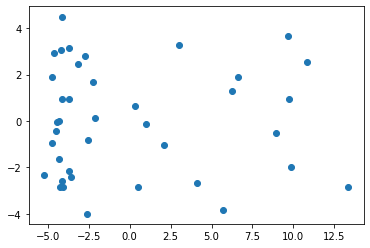

In [6]:
# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X)
Xpca = PCA(n_components=2).fit_transform(X)
plt.scatter(Xpca[:, 0], Xpca[:, 1])

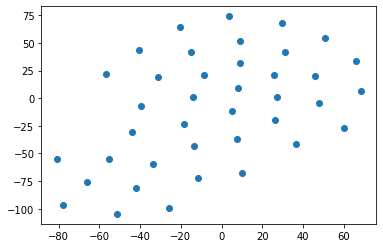

In [7]:
Xtsne = TSNE(n_components=2).fit_transform(X)
plt.scatter(Xtsne[:, 0], Xtsne[:, 1])

In [8]:
params = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 5,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}


# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)


# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
ward = cluster.AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")
dbscan = cluster.DBSCAN(eps=params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'],
                        xi=params['xi'],
                        min_cluster_size=params['min_cluster_size'])
affinity_propagation = cluster.AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters=params['n_clusters'], connectivity=connectivity)
birch = cluster.Birch(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')

clustering_algorithms = (
    ('MiniBatchKMeans', two_means),
    ('AffinityPropagation', affinity_propagation),
    #('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    #('DBSCAN', dbscan),
    #('OPTICS', optics),
    ('Birch', birch),
    ('GaussianMixture', gmm)
)

#### MeanShift, DBSCAN, and OPTICS are opted out as all the labels are recognized as outliners in our previous analysis

Silhouette Manhattan score for MiniBatchKMeans is: 0.07929466749271115
Silhouette Eulidean score for MiniBatchKMeans is: 0.05337103025581039


Silhouette Manhattan score for AffinityPropagation is: 0.08935519413518088
Silhouette Eulidean score for AffinityPropagation is: 0.06590728302464623


Silhouette Manhattan score for SpectralClustering is: 0.09449204521074418
Silhouette Eulidean score for SpectralClustering is: 0.07510673429624837


Silhouette Manhattan score for Ward is: 0.09687745212504077
Silhouette Eulidean score for Ward is: 0.07286464707632263


Silhouette Manhattan score for AgglomerativeClustering is: 0.2774177665847872
Silhouette Eulidean score for AgglomerativeClustering is: 0.18729162134807284


Silhouette Manhattan score for Birch is: 0.09687745212504077
Silhouette Eulidean score for Birch is: 0.07286464707632263


Silhouette Manhattan score for GaussianMixture is: 0.057187967802275246
Silhouette Eulidean score for GaussianMixture is: 0.04130235567068778




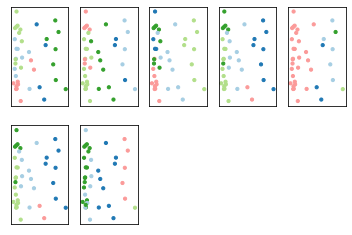

In [21]:
plot_num = 1
for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    #print("X is: ", X)
    #print("y_pred is: ", y_pred)

    plt.subplot(2, 5, plot_num)
    colors = np.array(list(islice(cycle(['#a6cee3','#1f78b4','#b2df8a','#33a02c',
                                         '#fb9a99','#e31a1c','#fdbf6f','#ff7f00',
                                         '#cab2d6']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(Xpca[:, 0], Xpca[:, 1], s=10, color=colors[y_pred])
    #plt.figure(figsize=(15,15))
    plt.xticks(())
    plt.yticks(())
    print("Silhouette Manhattan score for {} is:".format(name), silhouette_score(X, y_pred, metric='manhattan', sample_size=50))
    print("Silhouette Eulidean score for {} is:".format(name), silhouette_score(X, y_pred, metric='euclidean', sample_size=50))
    print("\n")
    if (name == 'AgglomerativeClustering'):
        y_pred_final = y_pred
    plot_num += 1

##### The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.
##### Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.
##### From the result metrics we can see that [AgglomerativeClustering] has the best performance among all clustering methods we implemented.

Silhouette Manhattan score for MiniBatchKMeans is: 0.08874096634998181
Silhouette Eulidean score for MiniBatchKMeans is: 0.06561007942795956


Silhouette Manhattan score for AffinityPropagation is: 0.08935519413518088
Silhouette Eulidean score for AffinityPropagation is: 0.06590728302464623


Silhouette Manhattan score for SpectralClustering is: 0.0944920452107442
Silhouette Eulidean score for SpectralClustering is: 0.07510673429624842


Silhouette Manhattan score for Ward is: 0.09687745212504081
Silhouette Eulidean score for Ward is: 0.07286464707632263


Silhouette Manhattan score for AgglomerativeClustering is: 0.27741776658478723
Silhouette Eulidean score for AgglomerativeClustering is: 0.18729162134807287


Silhouette Manhattan score for Birch is: 0.09687745212504079
Silhouette Eulidean score for Birch is: 0.07286464707632262


Silhouette Manhattan score for GaussianMixture is: 0.06014320279350404
Silhouette Eulidean score for GaussianMixture is: 0.05542753140438725




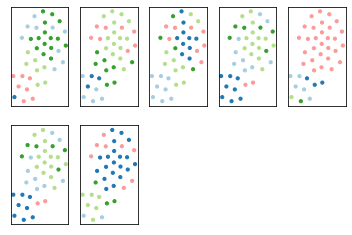

In [22]:
plot_num = 1
for name, algorithm in clustering_algorithms:
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding" +
            " may not work as expected.",
            category=UserWarning)
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)

    plt.subplot(2, 5, plot_num)

    colors = np.array(list(islice(cycle(['#a6cee3','#1f78b4','#b2df8a','#33a02c',
                                         '#fb9a99','#e31a1c','#fdbf6f','#ff7f00',
                                         '#cab2d6']),
                                  int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(Xtsne[:, 0], Xtsne[:, 1], s=10, color=colors[y_pred])

    plt.xticks(())
    plt.yticks(())
    print("Silhouette Manhattan score for {} is:".format(name), silhouette_score(X, y_pred, metric='manhattan', sample_size=50))
    print("Silhouette Eulidean score for {} is:".format(name), silhouette_score(X, y_pred, metric='euclidean', sample_size=50))
    print("\n")
    plot_num += 1

In [24]:
y_pred_final

array([2, 4, 4, 4, 0, 0, 1, 1, 3, 0, 0, 1, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [25]:
AccountSummary['pred'] = y_pred_final

In [28]:
AccountSummary.to_excel('data_mergered_pred.xlsx')